In [32]:
import pandas as pd
import matplotlib.pyplot as plt
from collections import Counter
import numpy as np

file_path = 'data/b_only_subset.csv'
out_B = 'data/csv/ucla_B.csv'
out_ret = 'data/csv/ucla_ret.csv'
out_smz = 'data/csv/ucla_smz.csv'
out_int = 'data/csv/ucla_int.csv'
out_cle = 'data/csv/ucla_cle.csv'
out_trl = 'data/csv/ucla_trl.csv'

df = pd.read_csv(out_int, delimiter=',')

In [33]:
df['figures'] = df['figures'].apply(lambda x: x.split(';') if isinstance(x, str) else [])
df['description'] = df['description'].apply(lambda x: x.split(';') if isinstance(x, str) else [])
df['genre'] = df['genre'].apply(lambda x: x.split(';') if isinstance(x, str) else [])

data_filtered = df[df['figures'].apply(lambda x: len(x) > 0)]
most_common_figure = data_filtered.groupby('year')['figures'].apply(lambda x: Counter(topic for topics in x for topic in topics).most_common(1)[0][0] if len(x) > 0 else None)
#print(most_common_figure)

data_filtered = df[df['description'].apply(lambda x: len(x) > 0)]
most_common_description = data_filtered.groupby('year')['description'].apply(lambda x: Counter(topic for topics in x for topic in topics).most_common(1)[0][0] if len(x) > 0 else None)
#print(most_common_description)

data_filtered = df[df['genre'].apply(lambda x: len(x) > 0)]
most_common_genre = data_filtered.groupby('year')['genre'].apply(lambda x: Counter(topic for topics in x for topic in topics).most_common(1)[0][0] if len(x) > 0 else None)
#print(most_common_genre)

In [34]:
import re
from collections import Counter

def flatten_list(strings):
    flattened_list = []
    for item in strings:
        if isinstance(item, str):  # If item is a string, add it directly to the flattened list
            flattened_list.append(item)
        else:  # If item is a list, recursively flatten it
            flattened_list.extend(flatten_list(item))
    return flattened_list

all_genre = flatten_list(df.genre)
counted_genre = Counter(all_genre)

all_description = flatten_list(df.description)
counted_description = Counter(all_description)

all_figures = flatten_list(df.figures)
counted_figures = Counter(all_figures)

#print(counted_genre)
#print(counted_description)
#print(counted_figures)

In [35]:
ten_most_common_genre = [item[0] for item in counted_genre.most_common(10)]

# Count records per genre
genre_counts = {}

# Iterate over each row in the DataFrame
for _, row in df.iterrows():
    year = row['year']
    genre_list = row['genre']
    
    # Iterate over each genre in the genres list for the current row
    for genre in genre_list:
        # Increment the count for the current genre and year
        genre_year = (genre, year)
        genre_counts[genre_year] = genre_counts.get(genre_year, 0) + 1

# Extract unique genres and years
genres = list(set([topic for topic, _ in genre_counts.keys()]))
years = list(set([year for _, year in genre_counts.keys()]))

# Sort the genres and years in ascending order
genres.sort()
years.sort()



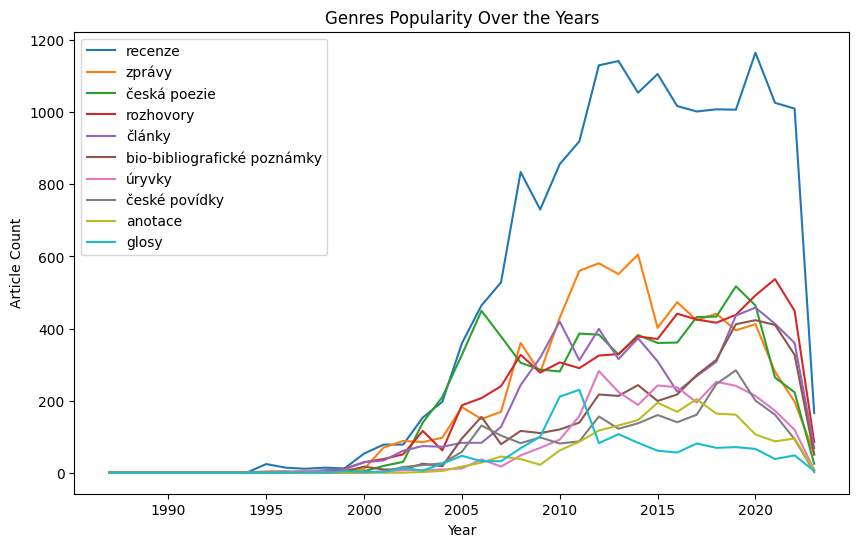

In [36]:
# Create a line chart
plt.figure(figsize=(10, 6))  # Set the figure size (optional)

# Plot the lines for each topic
for genre in ten_most_common_genre:
    counts = [genre_counts.get((genre, year), 0) for year in years]
    plt.plot(years, counts, label=genre)

# Add labels and title
plt.xlabel('Year')
plt.ylabel('Article Count')
plt.title('Genres Popularity Over the Years')

# Add a legend
plt.legend()  

# Display the chart
plt.show()